<a href="https://colab.research.google.com/github/Valerie231/ML_homeworks/blob/main/HW_2_8_%D0%9F%D0%BE%D0%BB%D1%96%D0%BD%D0%BE%D0%BC%D1%96%D0%B0%D0%BB%D1%8C%D0%BD%D1%96_%D0%BE%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import roc_curve, auc
import operator
from sklearn.preprocessing import PolynomialFeatures

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Colab Notebooks/

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Area under ROC score on Train dataset: 0.88%


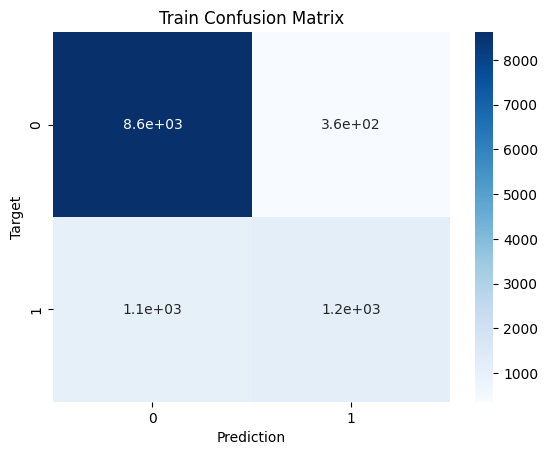

Area under ROC score on Validation dataset: 0.88%


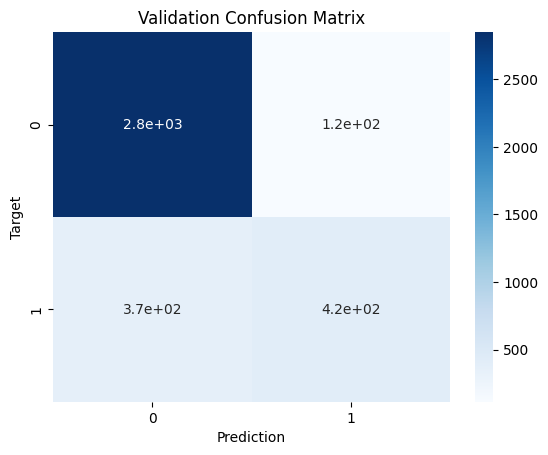

['customer_churn_pipeline.joblib']

In [3]:
raw_df = pd.read_csv('train.csv', index_col=0)

train_df, val_df = train_test_split(raw_df, test_size=0.25, random_state=42)

# Створюємо трен. і вал. набори
input_cols = ['CreditScore', 'Geography', 'Gender',	'Age',	'Tenure',	'Balance',
               'NumOfProducts',	'HasCrCard',	'IsActiveMember',	'EstimatedSalary']
target_col = ['Exited']

train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Виявляємо числові і категоріальні колонки
numeric_cols = raw_df[input_cols].select_dtypes(exclude='object').columns

categorical_cols = raw_df[input_cols].select_dtypes(include='object').columns

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    y_pred_proba = model_pipeline.predict_proba(inputs)[:, 1]
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds)
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'customer_churn_pipeline.joblib')

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Area under ROC score on Train dataset: 0.92%


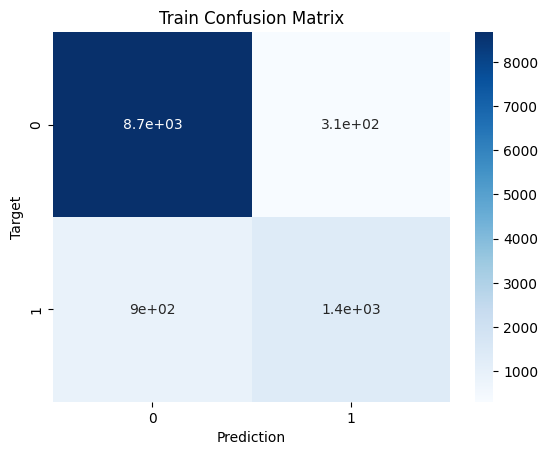

Area under ROC score on Validation dataset: 0.92%


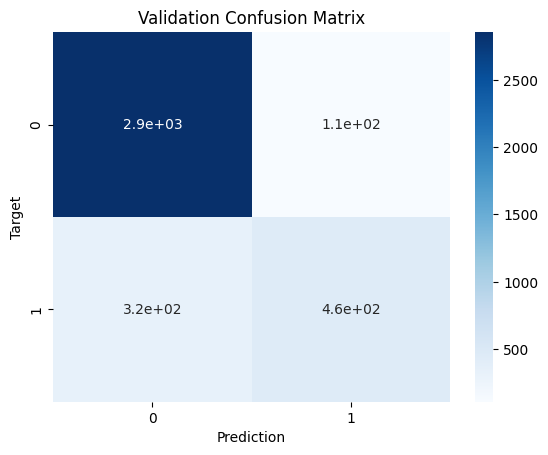

['customer_churn_pipeline.joblib']

In [4]:
# Комбінуємо трансформери для різних типів колонок в один препроцесор

numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2))
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    y_pred_proba = model_pipeline.predict_proba(inputs)[:, 1]
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds)
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'customer_churn_pipeline.joblib')

Area under the ROC curve is bigger end equal for both train and validation set when we add 2-degree polynomial - there is no over- or underfit

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Area under ROC score on Train dataset: 0.93%


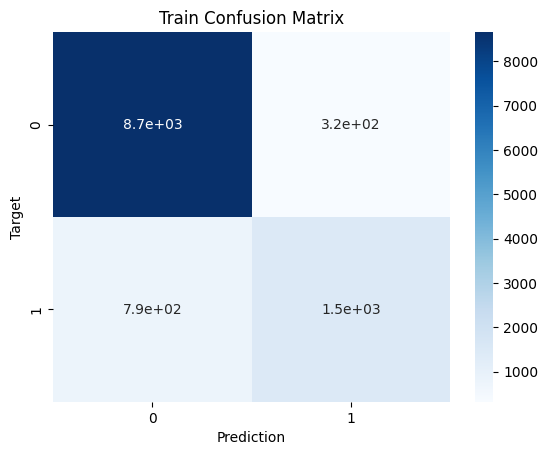

Area under ROC score on Validation dataset: 0.92%


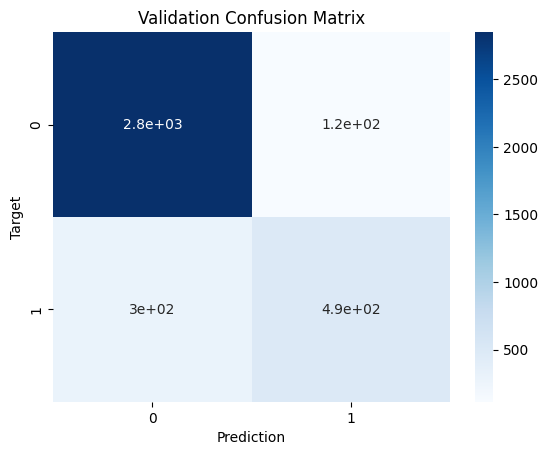

['customer_churn_pipeline.joblib']

In [5]:
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=3))
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    y_pred_proba = model_pipeline.predict_proba(inputs)[:, 1]
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds)
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'customer_churn_pipeline.joblib')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Area under ROC score on Train dataset: 0.94%


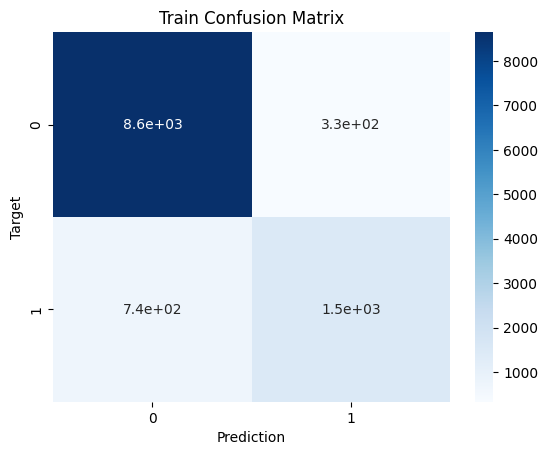

Area under ROC score on Validation dataset: 0.92%


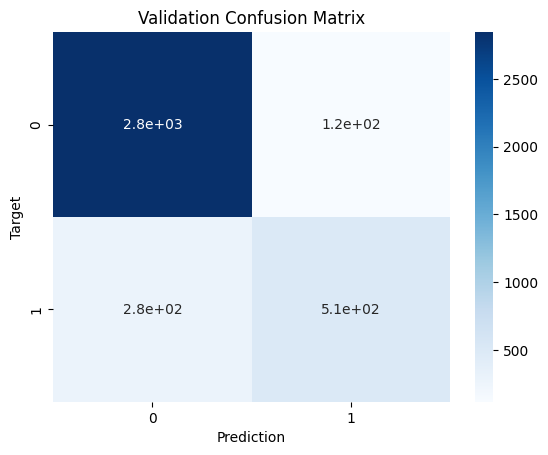

['customer_churn_pipeline.joblib']

In [6]:
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=4))
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    y_pred_proba = model_pipeline.predict_proba(inputs)[:, 1]
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds)
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'customer_churn_pipeline.joblib')

Для моделей з degree 3 і 4 спостерігаємо оверфіт, оскільки результати для тренувальних даних кращі, а для валідаційних такі ж як і для попередніх моделей

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [44]:
raw_df = pd.read_csv('regression_data.csv')

Train RMSE:  1.0664716922463597
Test RMSE:  0.8833273761660464


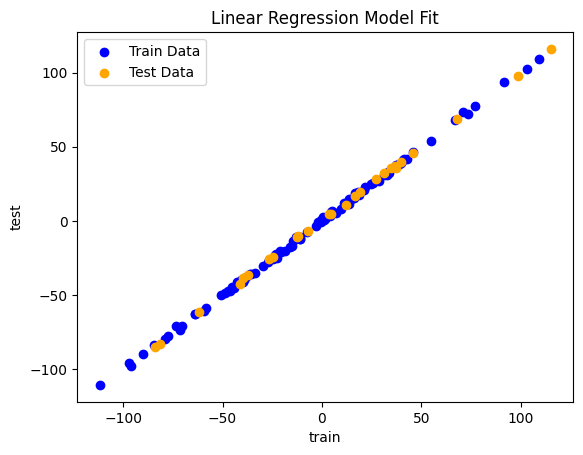

In [107]:
train_df, test_df = train_test_split(raw_df, test_size=0.2, random_state=42)

# Створюємо трен. і вал. набори
input_cols = raw_df.columns[:-1]
target_col = ['target']

train_inputs, train_targets = train_df[input_cols], train_df[target_col]
test_inputs, test_targets = test_df[input_cols], test_df[target_col]

# Створюємо трансформеp для числових колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, input_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(train_inputs, train_targets, test_inputs, test_targets):
  y_pred_train = model_pipeline.predict(train_inputs)
  y_pred_test = model_pipeline.predict(test_inputs)
  print('Train RMSE: ', mean_squared_error(train_targets, y_pred_train, squared=False))
  print('Test RMSE: ', mean_squared_error(test_targets, y_pred_test, squared=False))
  plt.scatter(train_targets, y_pred_train, color='blue', label='Train Data')
  plt.scatter(test_targets, y_pred_test, color='orange', label='Test Data')
  plt.xlabel('train')
  plt.ylabel('test')
  plt.title('Linear Regression Model Fit')
  plt.legend()
  plt.show()
  return y_pred_train, y_pred_test

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(train_inputs, train_targets, test_inputs, test_targets)

Train RMSE:  1.0166503745380442
Test RMSE:  1.0148514249660825


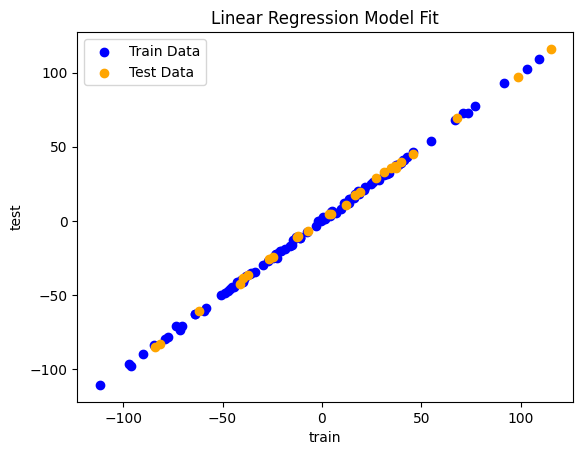

In [108]:
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, input_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(train_inputs, train_targets, test_inputs, test_targets)

Train RMSE:  1.0265474708672413
Test RMSE:  2.4850497888578897


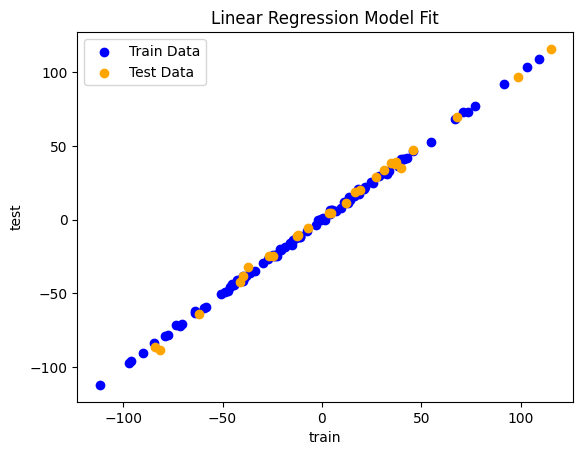

In [83]:
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=3))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, input_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(train_inputs, train_targets, test_inputs, test_targets)

Train RMSE:  9.927554225972347e-13
Test RMSE:  32.45281417655764


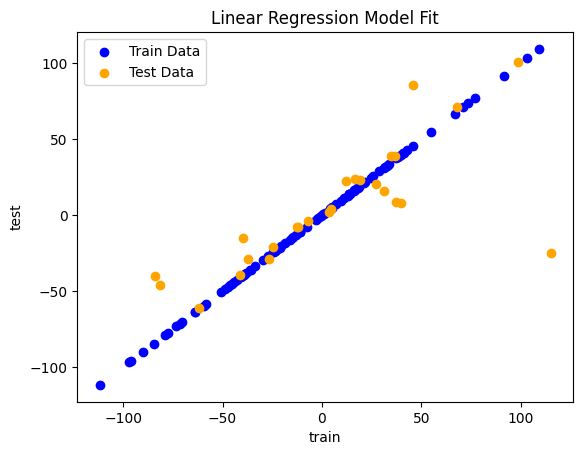

In [84]:
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=4))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, input_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(train_inputs, train_targets, test_inputs, test_targets)

Train RMSE:  4.254617600742442e-13
Test RMSE:  11.592518789258387


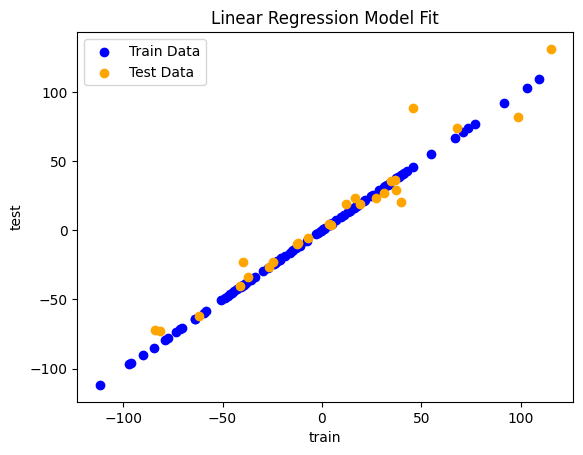

In [89]:
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=9))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, input_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(train_inputs, train_targets, test_inputs, test_targets)

In [90]:
train_rmse = []
test_rmse =[]
for i in range(20):
  numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=i))
  ])

  preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, input_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
  model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
  ])

# Тренуємо пайплайн
  model_pipeline.fit(train_inputs, train_targets)

# Оцінюємо модель на трен і вал даних
  y_pred_train = model_pipeline.predict(train_inputs)
  y_pred_test = model_pipeline.predict(test_inputs)
  train_rmse.append(mean_squared_error(train_targets, y_pred_train, squared=False))
  test_rmse.append(mean_squared_error(test_targets, y_pred_test, squared=False))

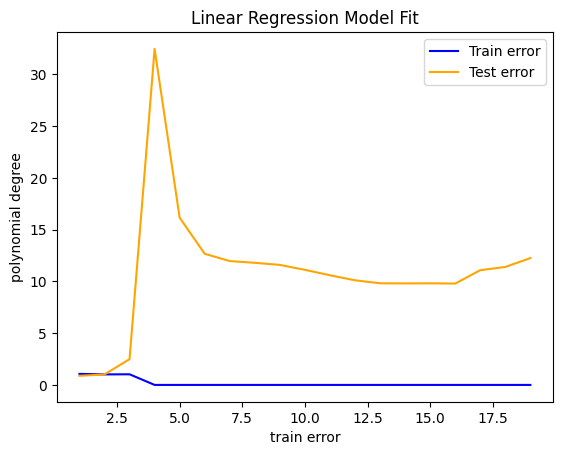

In [99]:
plt.plot(range(1,20), train_rmse[1:20], color='blue', label='Train error')
plt.plot(range(1,20), test_rmse[1:20], color='orange', label='Test error')
plt.xlabel('train error')
plt.ylabel('polynomial degree')
plt.title('Linear Regression Model Fit')
plt.legend()
plt.show()

In [106]:
test_rmse.index(np.min(test_rmse))

1

Найкраща модель з degree = 1, тобто лінійна, оскільки дані помилка для тестових даних стрімко зростає і спостерігається оверфіт


**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [109]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
models = [
    LinearRegression(),
    Ridge(),
    Ridge(alpha=2),
    Lasso(),
    ElasticNet(),
    ElasticNet(alpha=0.5)
]

In [110]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_metrics = mean_squared_error(y_train, y_train_pred, squared=False).round(6)
    test_metrics = mean_squared_error(y_test, y_test_pred, squared=False).round(6)

    return dict(train=train_metrics, test=test_metrics)

In [118]:
import warnings

warnings.filterwarnings("ignore")

for model in models:
  for i in range(1,20):
    poly_features = PolynomialFeatures(degree=i)
    X_train_poly = poly_features.fit_transform(train_inputs)
    X_test_poly = poly_features.transform(test_inputs)
    model.fit(X_train_poly, train_targets)
    eval_results  = evaluate_model(model, X_train_poly, train_targets, X_test_poly, test_targets)
    print(f'{str(model)}: {eval_results}\n')

LinearRegression(): {'train': 1.066472, 'test': 0.883327}

LinearRegression(): {'train': 1.01665, 'test': 1.014851}

LinearRegression(): {'train': 0.799271, 'test': 1.91596}

LinearRegression(): {'train': 0.0, 'test': 19.270418}

LinearRegression(): {'train': 0.0, 'test': 29.433497}

LinearRegression(): {'train': 0.0, 'test': 63.485169}

LinearRegression(): {'train': 0.0, 'test': 124.405712}

LinearRegression(): {'train': 0.0, 'test': 179.037358}

LinearRegression(): {'train': 0.0, 'test': 572.721813}

LinearRegression(): {'train': 0.0, 'test': 554.960995}

LinearRegression(): {'train': 0.0, 'test': 2375.789947}

LinearRegression(): {'train': 0.0, 'test': 1665.494804}

LinearRegression(): {'train': 0.0, 'test': 9115.983614}

LinearRegression(): {'train': 0.0, 'test': 4514.938917}

LinearRegression(): {'train': 0.0, 'test': 34084.94291}

LinearRegression(): {'train': 1e-06, 'test': 10187.58603}

LinearRegression(): {'train': 2e-06, 'test': 128146.763697}

LinearRegression(): {'train': 0

Найкращі результати показала лінійна регресія без поліноміальних ознак